# CNN classification

In [1]:
from fastai import *
from fastai.vision import *

In [26]:
folder = 'deadlift'
file = 'deadlift.txt'

In [29]:
folder = 'squat'
file = 'squat.txt'

In [32]:
folder = 'bench_press'
file = 'bench_press.txt'

In [33]:
path = Path('data/lifts')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

Finally, upload your urls file. You just need to press 'Upload' in your working directory and select your file, then click 'Upload' for each of the displayed files.

In [25]:
path.ls()

[PosixPath('data/lifts/deadlift'),
 PosixPath('data/lifts/squat'),
 PosixPath('data/lifts/bench_press'),
 PosixPath('data/lifts/bench_press.txt'),
 PosixPath('data/lifts/squat.txt'),
 PosixPath('data/lifts/deadlift.txt')]

In [34]:
download_images(path/file, dest, max_pics=200)

In [35]:
classes = ['deadlift','squat','bench_press']

Then we can remove any images that can't be opened:

In [36]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

deadlift


squat


bench_press


## View data

In [37]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [38]:
data.classes

['bench_press', 'deadlift', 'squat']

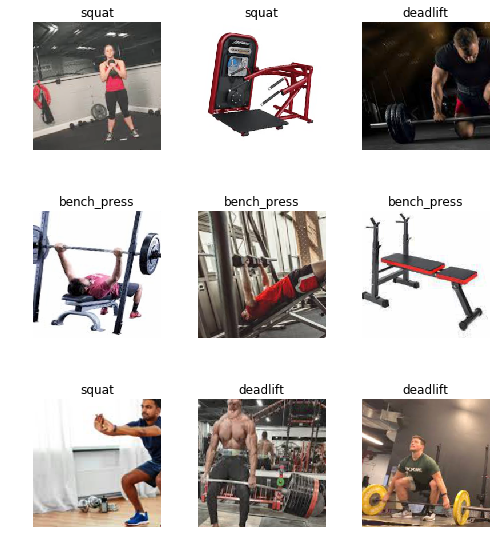

In [39]:
data.show_batch(rows=3, figsize=(7,8))

In [40]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['bench_press', 'deadlift', 'squat'], 3, 480, 120)

## Train model

In [41]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [42]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.422390,0.638621,0.166667,00:06
1,1.048456,0.558644,0.150000,00:04
2,0.829635,0.592712,0.158333,00:04
3,0.691370,0.585761,0.150000,00:04


In [43]:
# Saving the result, meaning the coefficient of the model
learn.save('stage-1')

In [44]:
learn.unfreeze()

In [45]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


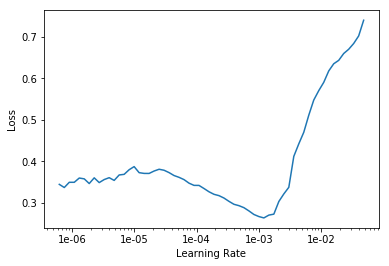

In [46]:
#Looking for the strongest downwards slope
learn.recorder.plot()

In [48]:
learn.fit_one_cycle(2, max_lr=slice(1e-05,1e-03))

epoch,train_loss,valid_loss,error_rate,time
0,0.141270,0.580681,0.141667,00:05
1,0.127687,0.464372,0.100000,00:06


Analyzing the learning rate we moved from an error rate of 0.150000 to 0.100000

In [49]:
learn.save('stage-2')

## Interpretation

In [50]:
learn.load('stage-2');

In [51]:
interp = ClassificationInterpretation.from_learner(learn)

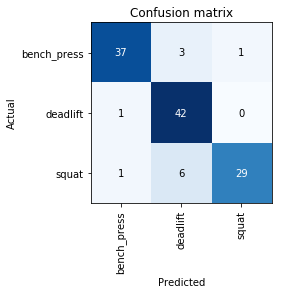

In [52]:
interp.plot_confusion_matrix()

In [53]:
#To see where the model is most confused
interp.most_confused()

[('squat', 'deadlift', 6),
 ('bench_press', 'deadlift', 3),
 ('bench_press', 'squat', 1),
 ('deadlift', 'bench_press', 1),
 ('squat', 'bench_press', 1)]

## Cleaning up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the ImageCleaner widget from fastai.widgets we can prune our top losses, removing photos that don't belong.

In [54]:
from fastai.widgets import *

First we need to get the file paths from our top_losses. We can do this with .from_toplosses. We then feed the top losses indexes and corresponding dataset to ImageCleaner.

Notice that the widget will not delete images directly from disk but it will create a new csv file cleaned.csv from where you can create a new ImageDataBunch with the corrected labels to continue training your model.

In [55]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

Then we create a new learner to use our new databunch with all the images.

In [56]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [57]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [58]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Flag photos for deletion by clicking 'Delete'. Then click 'Next Batch' to delete flagged photos and keep the rest in that row. ImageCleaner will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from top_losses.ImageCleaner(ds, idxs)

Make sure to recreate the databunch and learn_cln from the cleaned.csv file. Otherwise the file would be overwritten from scratch, losing all the results from cleaning the data from toplosses.

In [59]:
db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
                    .split_none()
                    .label_from_df()
                    .transform(get_transforms(), size=224)
                    .databunch()
      )

learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

In [60]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [61]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Remember to recreate your ImageDataBunch from your cleaned.csv to include the changes you made in your data!

In [62]:
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
                               ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

learn_cln = cnn_learner(data, models.resnet34, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


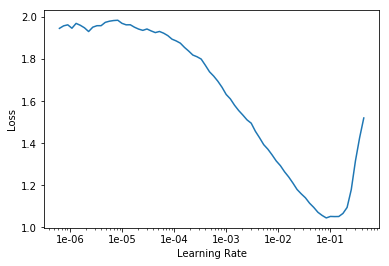

In [63]:
learn_cln.lr_find()
learn_cln.recorder.plot()

In [66]:
learn_cln.fit_one_cycle(4, max_lr=slice(1e-04,1e-01))

epoch,train_loss,valid_loss,error_rate,time
0,0.641065,1.668600,0.104348,00:04
1,0.506691,1.306167,0.104348,00:04
2,0.469849,1.120209,0.086957,00:04
3,0.395925,1.085344,0.086957,00:04


Cleaning the data we moved from an error rate of 0.100000 to 0.086957

## Putting the model in production

In [67]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [68]:
defaults.device = torch.device('cpu')

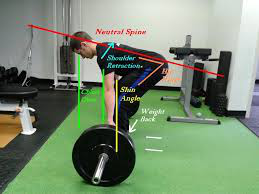

In [69]:
img = open_image(path/'deadlift'/'00000021.jpg')
img

We create our Learner in production enviromnent like this, just make sure that path contains the file 'export.pkl' from before.

In [70]:
learn = load_learner(path)

In [81]:
pred_class,pred_idx,outputs = learn.predict(img)
print(data.classes)
print(pred_class, pred_idx, outputs)

['bench_press', 'deadlift', 'squat']
deadlift tensor(1) tensor([1.2760e-04, 9.9987e-01, 2.3504e-07])


Here the predict class for our image is 'deadlift', which corresponds to a label of 1. The probabilities the model found for each class are [1.2760e-04, 9.9987e-01, 2.3504e-07] respectively, so its confidence is pretty high in the second label.